<a href="https://colab.research.google.com/github/vignesh99/SpeechTechnology-CS6300/blob/master/E2E_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
                                    #Get data files onto root
%cd
from google.colab import drive
drive.mount('/content/gdrive')
# !cp -avr /content/gdrive/My\ Drive/TIMIT\ E2E/timit.zip /root
# !unzip /root/timit.zip -d /root
!cp -avr /content/gdrive/My\ Drive/TIMIT\ E2E/Wordset\ files/* /root
!cp -avr /content/gdrive/My\ Drive/TIMIT\ E2E/Wordceps\ files/* /root
!ls

/root
Mounted at /content/gdrive
'/content/gdrive/My Drive/TIMIT E2E/Wordset files/inds.pkl' -> '/root/inds.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordset files/reps.pkl' -> '/root/reps.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordset files/wordset.pkl' -> '/root/wordset.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordset files/words.pkl' -> '/root/words.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/lenframes.pkl' -> '/root/lenframes.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/testfreqs.pkl' -> '/root/testfreqs.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/timitceps.pkl' -> '/root/timitceps.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/trainfreqs.pkl' -> '/root/trainfreqs.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/wordloop.pkl' -> '/root/wordloop.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/words.pkl' -> '/root/words.pkl'
'/content/gdrive/My Drive/TIMIT E2E/Wordceps files/Xtest.pkl' -> '/root/Xtest.pkl'
'/content/gdrive/M

In [2]:
                                    #Import libraries
from pylab import *
import os
from google.colab import files
!pip install pickle-mixin           #Use pkl to store model
from pickle import dump
from pickle import load      
!pip install SoundFile
import soundfile as sf              #For .wav to data
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc
import pandas as pd
import csv
import random
import time

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp36-none-any.whl size=6000 sha256=51414bff21851cb20b3ca5a90f4aa9b10f92bc0ee97a5df639de3b06d9c4a60d
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin
  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=aaa83ffbef8f9d465b95e1a0f65c8a10d43e4e649d21f51c1f3ae9cf3f281b9d
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [51]:
                                    #Import torch requirements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

In [49]:
#words = load(open('words.pkl', 'rb'))
#inds = load(open('inds.pkl', 'rb'))
reps = load(open('reps.pkl', 'rb'))
wordset = load(open('wordset.pkl', 'rb'))

Nreps = 250							#Number of repititions of each word

inds = np.where(reps >= Nreps)[0]
words = wordset[inds]               #Choose only 36-most-repeated words
freqs = reps[inds]                  #Frequency at which these words occur
print(len(inds))
print(words)
print(freqs)

27
['a' 'all' 'an' 'and' 'ask' 'carry' 'dark' "don't" 'greasy' 'had' 'in'
 'is' 'like' 'me' 'of' 'oily' 'rag' 'she' 'suit' 'that' 'the' 'to' 'wash'
 'water' 'year' 'you' 'your']
[ 866  543  571  481  464  463  465  488  462  526  944  399  511  505
  454  470  470  571  462  611 1602 1018  469  479  472  271  565]


In [50]:
def mostrepeatedwords(Nrep=250) :
    allwords = []
                                    #Go through all folders and consolidate the words
    for subdir, dirs, files in os.walk("timit_train"):
        dirname = subdir.split(os.path.sep)[-1]
        print('Directory:', dirname)
        for f in files:
            if f.endswith('.txt'):
                                    #Get words of each sentence from .txt file
                !cp -avr /root/timit_train/$dirname/$f /root
                words = np.genfromtxt(f,delimiter=' ',dtype=str)
                words = words[2:]
                words[-1] = words[-1][:-1]
                                    #Put all the words in a list
                allwords += list(map(str.lower,list(words)))
                !rm $f
                                    #Get the unique set of words and their counts
    wordunique,wordcount = np.unique(allwords,return_counts=True)
                                    #Choose only those words with significant repitions
    indrep = np.where(wordcount >= Nrep)[0]
    #print(len(indrep))
    wordclass = wordunique[indrep]
    return wordclass,wordunique,wordcount,indrep

In [6]:
# words,wordset,reps,inds = mostrepeatedwords()
# words

In [7]:
                                    #Dump words model file
# dump(words, open('words.pkl', 'wb'))
# dump(inds, open('inds.pkl', 'wb'))
# dump(reps, open('reps.pkl', 'wb'))
# dump(wordset, open('wordset.pkl', 'wb'))

In [8]:
                                    #Download model files
# files.download("/root/words.pkl")
# files.download("/root/inds.pkl")
# files.download("/root/reps.pkl")
# files.download("/root/wordset.pkl")

In [9]:
                                    #Getting the mfcc features for different words
def wavtoMfcc(words,Nmfcc=38) :
    count = 0                       #Initialize required lists
    timit_audio = []
    new_timit_audio = []
    timitceps = []
    wordloop = []
    lenframes = []
    for subdir, dirs, files in os.walk('timit_train'):
        dirname = subdir.split(os.path.sep)[-1]
        for f in files:
            if f.endswith('.wav'):
                count += 1
                print(os.path.join(subdir, f), ', name:', f, ', Count:', count)
                                    #Read data from the .wav file
                data, fs = sf.read(os.path.join(subdir, f))
                timit_audio.append(data)
                fword = f[:-4]+".wrd"
                                    #Check word files for most repeated words
                print(os.path.join(subdir, fword), ', name:', fword, ', Count:', count)
                word_file = np.array(pd.read_csv(os.path.join(subdir, fword), delimiter = ' ',header = None))
                new_data = []
                for w in np.array(word_file[:,2]):
                    if w in words:
                        a = np.where(word_file[:,2] == w)
                        start = word_file[a[0],0][0]
                        end = word_file[a[0],1][0]
                        if(start != end):   #For removing corner case error
                                    #Collect the .wav samples of required slices
                            new_data = data[start:end]
                            new_timit_audio.append(new_data)
                                            #Convert them to mfcc
                            ceps = mfcc(new_data, fs, numcep=Nmfcc,winlen=0.008,winstep=0.004,nfilt=76)
                            timitceps.append(ceps)
                                    #Put the words in order of the mfcc features
                            wordloop.append(w)
                            lenframes.append(len(ceps))
    
    timitceps = array(timitceps)
    wordloop = array(wordloop)
    lenframes = array(lenframes) 
    maxframes = lenframes.max()     #Obtain maximum size of frames

    return timitceps,wordloop,lenframes,maxframes,new_timit_audio                                           

In [10]:
# timitceps,wordloop,lenframes,maxframes,new_timit_audio = wavtoMfcc(words)

In [11]:
                                    #Dump processed files
# dump(timitceps, open('timitceps.pkl', 'wb'))
# dump(wordloop, open('wordloop.pkl', 'wb'))
# dump(lenframes, open('lenframes.pkl', 'wb'))
# dump(new_timit_audio, open('new_timit_audio.pkl', 'wb'))

In [12]:
                                    #Download model files
# files.download("/root/timitceps.pkl")
# files.download("/root/wordloop.pkl")
# files.download("/root/lenframes.pkl")
# files.download("/root/new_timit_audio.pkl")

In [13]:
                                    #Load the required files
# timitceps = load(open('timitceps.pkl', 'rb'))
# wordloop = load(open('wordloop.pkl', 'rb'))
# lenframes = load(open('lenframes.pkl', 'rb'))
# new_timit_audio = load(open('new_timit_audio.pkl', 'rb'))

In [14]:
def mfcctotensor(words,trainfreqs,testfreqs,timitceps,wordloop,lenframes,maxframes=162,Nmfcc=38) :
                                    #Declare train and test arrays
    Xtrain = np.zeros((sum(trainfreqs),maxframes,Nmfcc))
    Xtest = np.zeros((sum(testfreqs),maxframes,Nmfcc))
    Ytrain = np.zeros(sum(trainfreqs))
    Ytest = np.zeros(sum(testfreqs))
    indtrain = cumsum(trainfreqs)   #Cumulative sum of indices
    indtest = cumsum(testfreqs)
                                    #Loop to collect train and test features
    for i in range(0,len(words)) :
    
                                    #Obtain the particular word's mfcc features
        indcep = np.where(wordloop==words[i])[0]
        indlen = lenframes[indcep]
                                    #Can add randomness if needed (while choosing for train and test)
        trainindcep = indcep[:trainfreqs[i]]
        testindcep = indcep[trainfreqs[i]:]
        trainindlen = indlen[:trainfreqs[i]]
        testindlen = indlen[trainfreqs[i]:]
                                    #Check if occurance match
        if trainfreqs[i] + testfreqs[i] == len(indcep) :            
                                    #Loop over train features and transfer from list to array
            for j in range(0,len(trainindcep)) :
                if i != 0 :
                    Xtrain[indtrain[i-1]+j][:trainindlen[j]] = timitceps[trainindcep[j]]
                else :
                    Xtrain[j][:trainindlen[j]] = timitceps[trainindcep[j]]
                                    #Loop over test features and transfer from list to array
            for j in range(0,len(testindcep)) :
                if i != 0 :
                    Xtest[indtest[i-1]+j][:testindlen[j]] = timitceps[testindcep[j]]
                else :
                    Xtest[j][:testindlen[j]] = timitceps[testindcep[j]]
        else :
            print("ERROR : Frequencies don't match with index length")
            return None
                                    #Assign outputs for ANN
        if i == 0 :
            Ytrain[:indtrain[i]] = i
            Ytest[:indtest[i]] = i
        else :
            Ytrain[indtrain[i-1]:indtrain[i]] = i
            Ytest[indtest[i-1]:indtest[i]] = i

    return Xtrain,Ytrain,Xtest,Ytest,words,trainfreqs,testfreqs

In [15]:
def traintesttensors(timitceps,wordloop,lenframes,Nmfcc=38) :
                                    #Get required inputs
    words,freqs = np.unique(wordloop,return_counts=True)
    trainfreqs = np.round(0.8*freqs.astype("float"))
    testfreqs = freqs-trainfreqs
    maxframes = lenframes.max()

    return mfcctotensor(words,trainfreqs.astype("int"),testfreqs.astype("int"),timitceps,wordloop,lenframes,maxframes)

In [16]:
# Xtrain,Ytrain,Xtest,Ytest,words,trainfreqs,testfreqs = traintesttensors(timitceps,wordloop,lenframes)

In [17]:
                                    #Dump processed files
# dump(Xtrain, open('Xtrain.pkl', 'wb'))
# dump(Ytrain, open('Ytrain.pkl', 'wb'))
# dump(Xtest, open('Xtest.pkl', 'wb'))
# dump(Ytest, open('Ytest.pkl', 'wb'))
# dump(words, open('words.pkl', 'wb'))
# dump(trainfreqs, open('trainfreqs.pkl', 'wb'))
# dump(testfreqs, open('testfreqs.pkl', 'wb'))

In [18]:
                                    #Download model files
# files.download("/root/Xtrain.pkl")
# files.download("/root/Ytrain.pkl")
# files.download("/root/Xtest.pkl")
# files.download("/root/Ytest.pkl")
# files.download("/root/words.pkl")
# files.download("/root/trainfreqs.pkl")
# files.download("/root/testfreqs.pkl")

In [19]:
                                    #Load files
Xtrain = load(open('Xtrain.pkl', 'rb'))
Ytrain = load(open('Ytrain.pkl', 'rb'))
Xtest = load(open('Xtest.pkl', 'rb'))
Ytest = load(open('Ytest.pkl', 'rb'))
words = load(open('words.pkl', 'rb'))
# trainfreqs = load(open('trainfreqs.pkl', 'rb'))
# testfreqs = load(open('testfreqs.pkl', 'rb'))

In [20]:

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size,feature_size,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.feature_size = feature_size
        self.batch_size = batch_size

        self.gru = nn.GRU(feature_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [21]:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, feature_size, output_size,batch_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.feature_size = feature_size
        self.batch_size = batch_size

        self.gru = nn.GRU(feature_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        #print(input.size())
        output = F.relu(input)
        #output = input
        #print(output.size())
        output, hidden = self.gru(output, hidden)
        #print(output.size())
        output = self.out(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [39]:
teacher_forcing_ratio = 0.5
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 162

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,feature_size, max_length=MAX_LENGTH):
                                    #Initialize hidden vector
    encoder_hidden = encoder.initHidden()
                                    #Make the gradients zero
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
                                    #No. of windows/ dependent units
    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)
                                    #Storing outputs for attention
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
                                    #Loop over the no. of windows
    for ei in range(input_length):
                                    #Call encoder (?)
        encoder_output, encoder_hidden = encoder(
            input_tensor[:,ei].unsqueeze(0), encoder_hidden)
            #input_tensor[:,ei].view(1,-1,feature_size), encoder_hidden)
        #print(encoder_output[0,0])
        encoder_outputs[ei] = encoder_output[0, 0]
                                    #Initialize decoder input (?)
    decoder_input = torch.zeros(1,input_tensor.size(0),input_tensor.size(2), device=device)
    
                                    #Use common hidden layer
    decoder_hidden = encoder_hidden
    #print(encoder_hidden.size())

    use_teacher_forcing = True#True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
                                    #Call decoder (?)
            #print(decoder_input.size())
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
                                    #Comparing same decoder output with different target vectors (?)
            loss += criterion(decoder_output, target_tensor[:,di].unsqueeze(0))
                                    #Teacher forcing
            decoder_input = target_tensor[:,di].unsqueeze(0)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input.unsqueeze(0), decoder_hidden)
            #topv, topi = decoder_output.topk(1)
            #decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[:,di].unsqueeze(0))
            # if decoder_input.item() == EOS_token:
            #     break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [40]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    #loc = matplotlib.ticker.MultipleLocator(base=0.2)
    #ax.yaxis.set_major_locator(loc)
    plt.semilogy(points)

In [83]:
def trainIters(dataloader, encoder, decoder, n_iters,feature_size, print_every=1, plot_every=1, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    batchloss = 0                   #Reset after every epoch
    print_loss_total = 0            #Reset every print_every
    plot_loss_total = 0             #Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for iter in range(1, n_iters + 1):
        for i,input in enumerate(dataloader) :
            input_tensor = input[0]
            target_tensor = input[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion,feature_size)
            batchloss += loss
        print_loss_total += batchloss
        plot_loss_total += batchloss
        batchloss = 0

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
                                    #Make it zero after every print
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                        iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #print(plot_losses)
    showPlot(plot_losses)

0m 11s (- 22m 47s) (1 0%) 2427.8442
0m 23s (- 22m 41s) (2 1%) 1957.5138
0m 34s (- 22m 29s) (3 2%) 1752.0534
0m 46s (- 22m 17s) (4 3%) 1631.4611
0m 57s (- 22m 3s) (5 4%) 1559.1637
1m 8s (- 21m 50s) (6 5%) 1504.7926
1m 20s (- 21m 40s) (7 5%) 1461.2966
1m 32s (- 21m 29s) (8 6%) 1436.0647
1m 43s (- 21m 17s) (9 7%) 1410.2287
1m 55s (- 21m 6s) (10 8%) 1395.2342
2m 6s (- 20m 56s) (11 9%) 1385.3030
2m 18s (- 20m 44s) (12 10%) 1367.1233
2m 29s (- 20m 33s) (13 10%) 1356.0595
2m 41s (- 20m 22s) (14 11%) 1346.2867
2m 53s (- 20m 11s) (15 12%) 1338.3442
3m 4s (- 19m 59s) (16 13%) 1335.5308
3m 16s (- 19m 48s) (17 14%) 1324.6438
3m 27s (- 19m 37s) (18 15%) 1317.8240
3m 39s (- 19m 26s) (19 15%) 1315.3931
3m 50s (- 19m 14s) (20 16%) 1310.2945
4m 2s (- 19m 3s) (21 17%) 1302.5039
4m 14s (- 18m 53s) (22 18%) 1296.0322
4m 25s (- 18m 41s) (23 19%) 1292.4670
4m 37s (- 18m 29s) (24 20%) 1289.8247
4m 49s (- 18m 18s) (25 20%) 1283.2206
5m 0s (- 18m 6s) (26 21%) 1275.0509
5m 12s (- 17m 55s) (27 22%) 1275.3409
5m 

<Figure size 432x288 with 0 Axes>

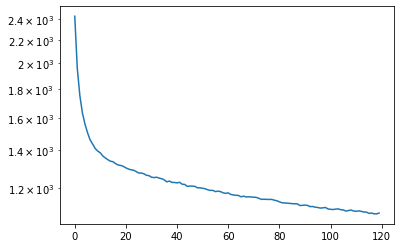

In [84]:
                                    #Create dataloader
trainIp = torch.from_numpy(Xtrain[:1000]).float().to(device)
traindata = TensorDataset(trainIp,trainIp)
dataloader = DataLoader(dataset=traindata,
                        batch_size=20,
                        shuffle=True,
                        drop_last=True)
hidden_size = 256
feature_size = 38
output_size = 38
batch_size = 20
device = torch.device('cuda')
encoder = EncoderRNN(hidden_size,feature_size,batch_size).to(device)
decoder = DecoderRNN(hidden_size,feature_size,output_size,batch_size).to(device)
trainIters(dataloader,encoder, decoder, 120,feature_size)

In [ ]:
for i,data in enumerate(dataloader) :
    print(i)
    print(shape(data[0]))
    print((data[0]==data[1]).all())

In [ ]:

input = torch.from_numpy(Xtrain[:batch_size]).float().to(device)
#print(input.size())
#input = input.view(1,162,-1)
#print(input.size())

In [37]:
shape(Xtrain)

(12520, 162, 38)

In [54]:
teacher_forcing_ratio = 0.5


def trainAttention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
MAX_LENGTH = 162
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, feature_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.feature_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
a = np.where(wordloop=="carry")[0]
shape(timitceps[a[5]])
#wordloop[2]

(73, 38)

In [ ]:
wordloop[np.where(lenframes==lenframes.min())[0]]
#wavfile.write('test.wav', 16000, new_timit_audio[15545])

array(['to', 'a'], dtype='<U6')

In [ ]:
print(type(timitceps[0]))
_,check = array(np.unique(wordloop,return_counts=True))
print(sum(np.round(0.8*check.astype(float))))#/sum(check.astype(float)))
(0.8*check.astype(float))
sum(check.astype(float))
a = array([2,3,4,5,6])
cumsum(a)

<class 'numpy.ndarray'>
12520.0


array([ 2,  5,  9, 14, 20])

In [ ]:
print(lenframes.max())
lenframes.min()

162


3

In [ ]:
print(words)
print(freqs)

['a' 'all' 'an' 'and' 'are' 'ask' 'be' 'carry' 'dark' "don't" 'for'
 'greasy' 'had' 'he' 'his' 'in' 'is' 'like' 'me' 'of' 'oily' 'on' 'rag'
 'she' 'suit' 'that' 'the' 'to' 'was' 'wash' 'water' 'we' 'with' 'year'
 'you' 'your']
[ 866  543  571  481  237  464  175  463  465  488  216  462  526  233
  189  944  399  511  505  454  470  164  470  571  462  611 1602 1018
  235  469  479  154  187  472  271  565]


In [ ]:
files.download("test.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>